In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', skip=1)

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RIPK1,1.3446108,1.965071,1.1286371,1.470146,1.615045,1.405978,1.615045,1.615045,1.855199,⋯,1.405978,1.3048955,1.281862,2.311079,2.4165559,1.444033,1.223975,1.405978,1.405978,1.489246
IL20RB,1.0793750,1.128637,0.8553470,1.223975,1.615045,1.405978,1.615045,1.615045,1.615045,⋯,1.615045,1.4534241,1.281862,1.615045,1.2239751,1.094372,1.405978,1.524744,1.223975,1.040725
VEGFA,1.4581924,1.489246,1.5247437,1.065532,1.615045,1.405978,1.615045,1.615045,1.855199,⋯,1.296464,0.9589023,1.281862,1.405978,1.2239751,1.257103,2.311079,1.524744,1.751471,1.489246
MUTYH,1.3446108,1.405978,0.9825357,1.223975,1.615045,1.405978,1.615045,1.615045,1.615045,⋯,1.405978,0.8456178,1.281862,1.405978,1.0655322,1.094372,1.405978,1.223975,1.405978,1.577444
CD48,0.8180133,1.128637,0.8553470,1.405978,1.615045,1.405978,1.615045,1.615045,1.615045,⋯,1.296464,1.3821764,1.472473,1.405978,0.9275997,1.094372,1.405978,1.615045,1.223975,1.577444
CDK6,1.6360265,1.128637,2.5660410,1.065532,1.615045,1.405978,1.615045,1.615045,1.615045,⋯,1.128637,1.3576251,1.281862,1.405978,0.9275997,4.377488,2.447950,2.447950,1.223975,3.122176


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    mutate(`region_type`=case_when(
        `region_type` == 't' ~ 'tumor',
        TRUE ~ `region_type`
    )) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

exp_tbl %>%
    head()

gene_symbol,sample_desc,sample_name,region_id,region_type,marker,norm_exp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
RIPK1,NMS23-471 | 001 | S100B,NMS23-471,001,tumor,S100B,1.344611
RIPK1,NMS23-471 | 002 | S100B,NMS23-471,002,tumor,S100B,1.965071
RIPK1,NMS23-471 | 003 | S100B,NMS23-471,003,tumor,S100B,1.128637
RIPK1,NMS23-471 | 004 | S100B,NMS23-471,004,tumor,S100B,1.470146
RIPK1,NMS23-471 | 005 | CD68,NMS23-471,005,peritumor,CD68,1.615045
RIPK1,NMS23-471 | 005 | CD3,NMS23-471,005,peritumor,CD3,1.405978


In [6]:
samples_of_interest <-
    sample_annotations %>%
    filter(
        `marker` == 'S100B',
        `sample_name` != 'NMS23-471'
    )

samples_of_interest

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS22-289343 | 001 | S100B,NMS22-289343,001,S100B,tumor
NMS22-289343 | 002 | S100B,NMS22-289343,002,S100B,tumor
NMS22-289343 | 003 | S100B,NMS22-289343,003,S100B,tumor
NMS22-289343 | 004 | S100B,NMS22-289343,004,S100B,tumor
NMS22-289343 | 005 | S100B,NMS22-289343,005,S100B,tumor
NMS22-289343 | 006 | S100B,NMS22-289343,006,S100B,tumor
NMS22-289343 | 007 | S100B,NMS22-289343,007,S100B,peritumor
NMS22-289343 | 012 | S100B,NMS22-289343,012,S100B,peritumor
S08-25548 | 001 | DAPI,S08-25548,001,S100B,peritumor


In [7]:
exp_matrix_dge <-
    exp_matrix %>%
    select(-`TargetName`) %>%
    select(all_of(samples_of_interest$`sample_desc`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix %>% select(`TargetName`) %>% pull
        
        x
    }) 

exp_matrix_dge

,NMS22-289343 | 001 | S100B,NMS22-289343 | 002 | S100B,NMS22-289343 | 003 | S100B,NMS22-289343 | 004 | S100B,NMS22-289343 | 005 | S100B,NMS22-289343 | 006 | S100B,NMS22-289343 | 007 | S100B,NMS22-289343 | 012 | S100B,S08-25548 | 001 | DAPI,S08-25548 | 002 | DAPI,⋯,S08-25548 | 015 | DAPI,S10-479 | 001 | S100,S10-479 | 004 | S100,S10-479 | 005 | S100,S10-479 | 010 | S100,S10-479 | 011 | S100,S10-479 | 012 | S100,S10-479 | 013 | S100,S10-479 | 014 | S100,S10-479 | 015 | S100
RIPK1,1.615045,1.489246,1.615045,1.296464,1.3538875,1.615045,1.615045,1.615045,1.615045,1.405978,⋯,1.6656124,1.855199,1.296464,1.405978,1.687255,1.0190244,1.751471,1.3048955,2.4165559,1.405978
IL20RB,1.615045,1.128637,1.823194,1.489246,1.2484304,1.615045,1.615045,1.615045,1.223975,1.405978,⋯,0.9620482,1.405978,1.710694,1.615045,1.125764,1.1051032,1.405978,1.4534241,1.2239751,1.524744
VEGFA,1.615045,1.296464,1.296464,1.040725,1.7224964,1.615045,1.615045,1.615045,1.899420,1.405978,⋯,0.8986371,1.405978,1.296464,1.405978,1.088154,1.0793750,1.405978,0.9589023,1.2239751,1.524744
MUTYH,1.615045,1.405978,1.128637,1.195479,1.2484304,1.615045,1.615045,1.615045,1.524744,1.405978,⋯,1.8063096,1.405978,1.296464,1.405978,1.497633,1.3446108,1.405978,0.8456178,1.0655322,1.223975
CD48,1.615045,1.751471,1.128637,1.373245,1.1786275,1.615045,1.615045,1.615045,1.405978,1.615045,⋯,1.1051032,1.405978,1.296464,1.405978,1.148452,1.3446108,1.405978,1.3821764,0.9275997,1.615045
CDK6,1.615045,1.128637,1.128637,2.081450,0.9461333,1.615045,1.615045,1.615045,1.223975,1.405978,⋯,2.7380816,1.405978,2.592927,1.405978,1.945865,2.1363657,1.405978,1.3576251,0.9275997,2.447950
RRAS2,1.855199,1.128637,1.128637,1.710694,1.3538875,1.615045,1.615045,1.615045,1.405978,1.405978,⋯,1.4382096,1.855199,1.489246,1.615045,1.624140,1.8551994,1.405978,2.3815556,1.0655322,1.751471
KRT7,1.615045,1.128637,1.128637,1.040725,0.9461333,1.615045,1.615045,1.615045,1.542112,1.405978,⋯,0.4928238,1.405978,1.296464,1.405978,1.349187,0.8972174,1.405978,0.9790171,1.1687024,1.223975
WNT3A,1.615045,1.710694,1.296464,1.615045,1.2484304,1.615045,1.615045,1.615045,1.524744,1.855199,⋯,0.8871123,1.405978,1.296464,1.405978,1.172909,0.9396505,1.405978,1.1696263,1.0655322,1.615045
GIMAP6,1.615045,1.557214,1.296464,1.296464,1.0868218,1.615045,1.615045,1.855199,2.011911,1.405978,⋯,1.5445522,1.405978,1.855199,1.615045,1.537145,0.8180133,1.615045,1.7051000,1.7514706,1.223975


In [8]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~`region_type`)

exp_model

,(Intercept),region_typetumor
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,0
8,1,0
9,1,0
10,1,0


In [9]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [10]:
all_table <-
    topTable(all_fit, adjust.method='bonferroni', n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL18RAP,0.4300642,9.294041,5.126194,8.674314e-06,0.01704503,3.51709297
MAP3K5,0.4941282,9.390538,5.095994,9.539686e-06,0.01874548,3.09595314
MICA,-0.3674559,9.265913,-4.592235,4.598126e-05,0.09035317,1.99700193
IL10RA,0.3048568,9.301870,4.532386,5.531039e-05,0.10868491,1.82971232
RFC4,0.3910892,9.363707,4.530079,5.570508e-05,0.10946047,1.79938980
FUT5,-0.4100951,9.228391,-4.367641,9.169827e-05,0.18018709,1.37203512
NUPR1,-0.8484376,9.410440,-4.328570,1.033078e-04,0.20299977,1.12498277
CCND2,0.2875226,9.310211,4.290980,1.158314e-04,0.22760863,1.15637928
MET,-0.3361428,9.279358,-4.288549,1.166909e-04,0.22929755,1.15380489


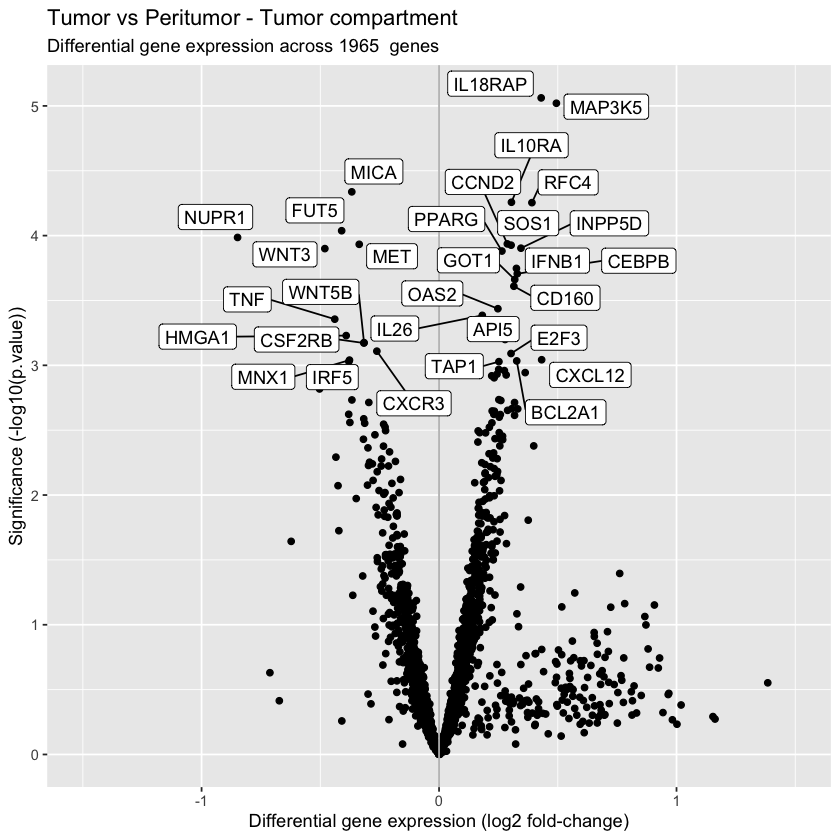

In [13]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 2 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 3 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - Tumor compartment',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-1.5, 1.5)
